In [1]:
import numpy as np               # linear algebra
import pandas as pd              # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns            #Statistical Data Visualization
import warnings
import os
from IPython.display import Image, display
import matplotlib.font_manager as fm

%pylab inline

plt.style.use('seaborn-darkgrid')
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Outils document

In [3]:
def createColumnsQualitatives(donnees,col):
    varListe = list()
    valeurs = donnees[col].sort_values().unique()
    for i in valeurs : 
        nom = col+'_'+str(i)
        donnees[nom] = donnees[col].apply(lambda x : 1 if x==i else 0)
        varListe.append(nom)
    donnees.drop(labels=col, axis=1, inplace=True)
    return varListe

In [4]:
def afficheDendrogram(*args, **kwargs):
    font1 = fm.FontProperties(size=20)
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Classification Hiérarchique Ascendante', 
                  fontproperties=font2)
        plt.xlabel("index de l'échantillon ou (taille du cluster)", fontproperties=font1)
        plt.ylabel('distance', fontproperties=font1)
        plt.xticks(fontproperties=font1)
        plt.yticks(fontproperties=font1)
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center', fontproperties=font1)
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# Lecture de données 

In [5]:
donnees = pd.read_csv('BankChurners.csv', index_col='CLIENTNUM')
donnees.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                      'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
               inplace=True)

donnees.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [6]:
varQualitatives = ['Attrition_Flag',
                      'Gender',
                      'Education_Level',
                      'Marital_Status',
                      'Income_Category',
                      'Card_Category',
                      'Dependent_count',
                      'Total_Relationship_Count',
                      'Months_Inactive_12_mon',
                      'Contacts_Count_12_mon']
varQuantitatives = ['Credit_Limit',
                    'Avg_Open_To_Buy',
                    'Total_Amt_Chng_Q4_Q1',
                    'Total_Ct_Chng_Q4_Q1',
                    'Avg_Utilization_Ratio',
                   ]
varQuantitativesDiscretes = ['Customer_Age',
                             'Months_on_book',
                             'Total_Revolving_Bal',
                             'Total_Trans_Amt',
                             'Total_Trans_Ct']

In [8]:
donnees[varQuantitatives].head()

,Credit_Limit,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,
768805383,12691.0,11914.0,1.335,1.625,0.061
818770008,8256.0,7392.0,1.541,3.714,0.105
713982108,3418.0,3418.0,2.594,2.333,0.000
769911858,3313.0,796.0,1.405,2.333,0.760
709106358,4716.0,4716.0,2.175,2.500,0.000


# Transformation des variables qualitatives

In [10]:
varQualitativesT = list()
for nom in varQualitatives:
    temp = createColumnsQualitatives(donnees,nom)
    varQualitativesT = varQualitativesT + temp

# Classification ascendante hiérarchique
**Jeu de données initial**

In [12]:
Z = linkage(donnees, method='ward')

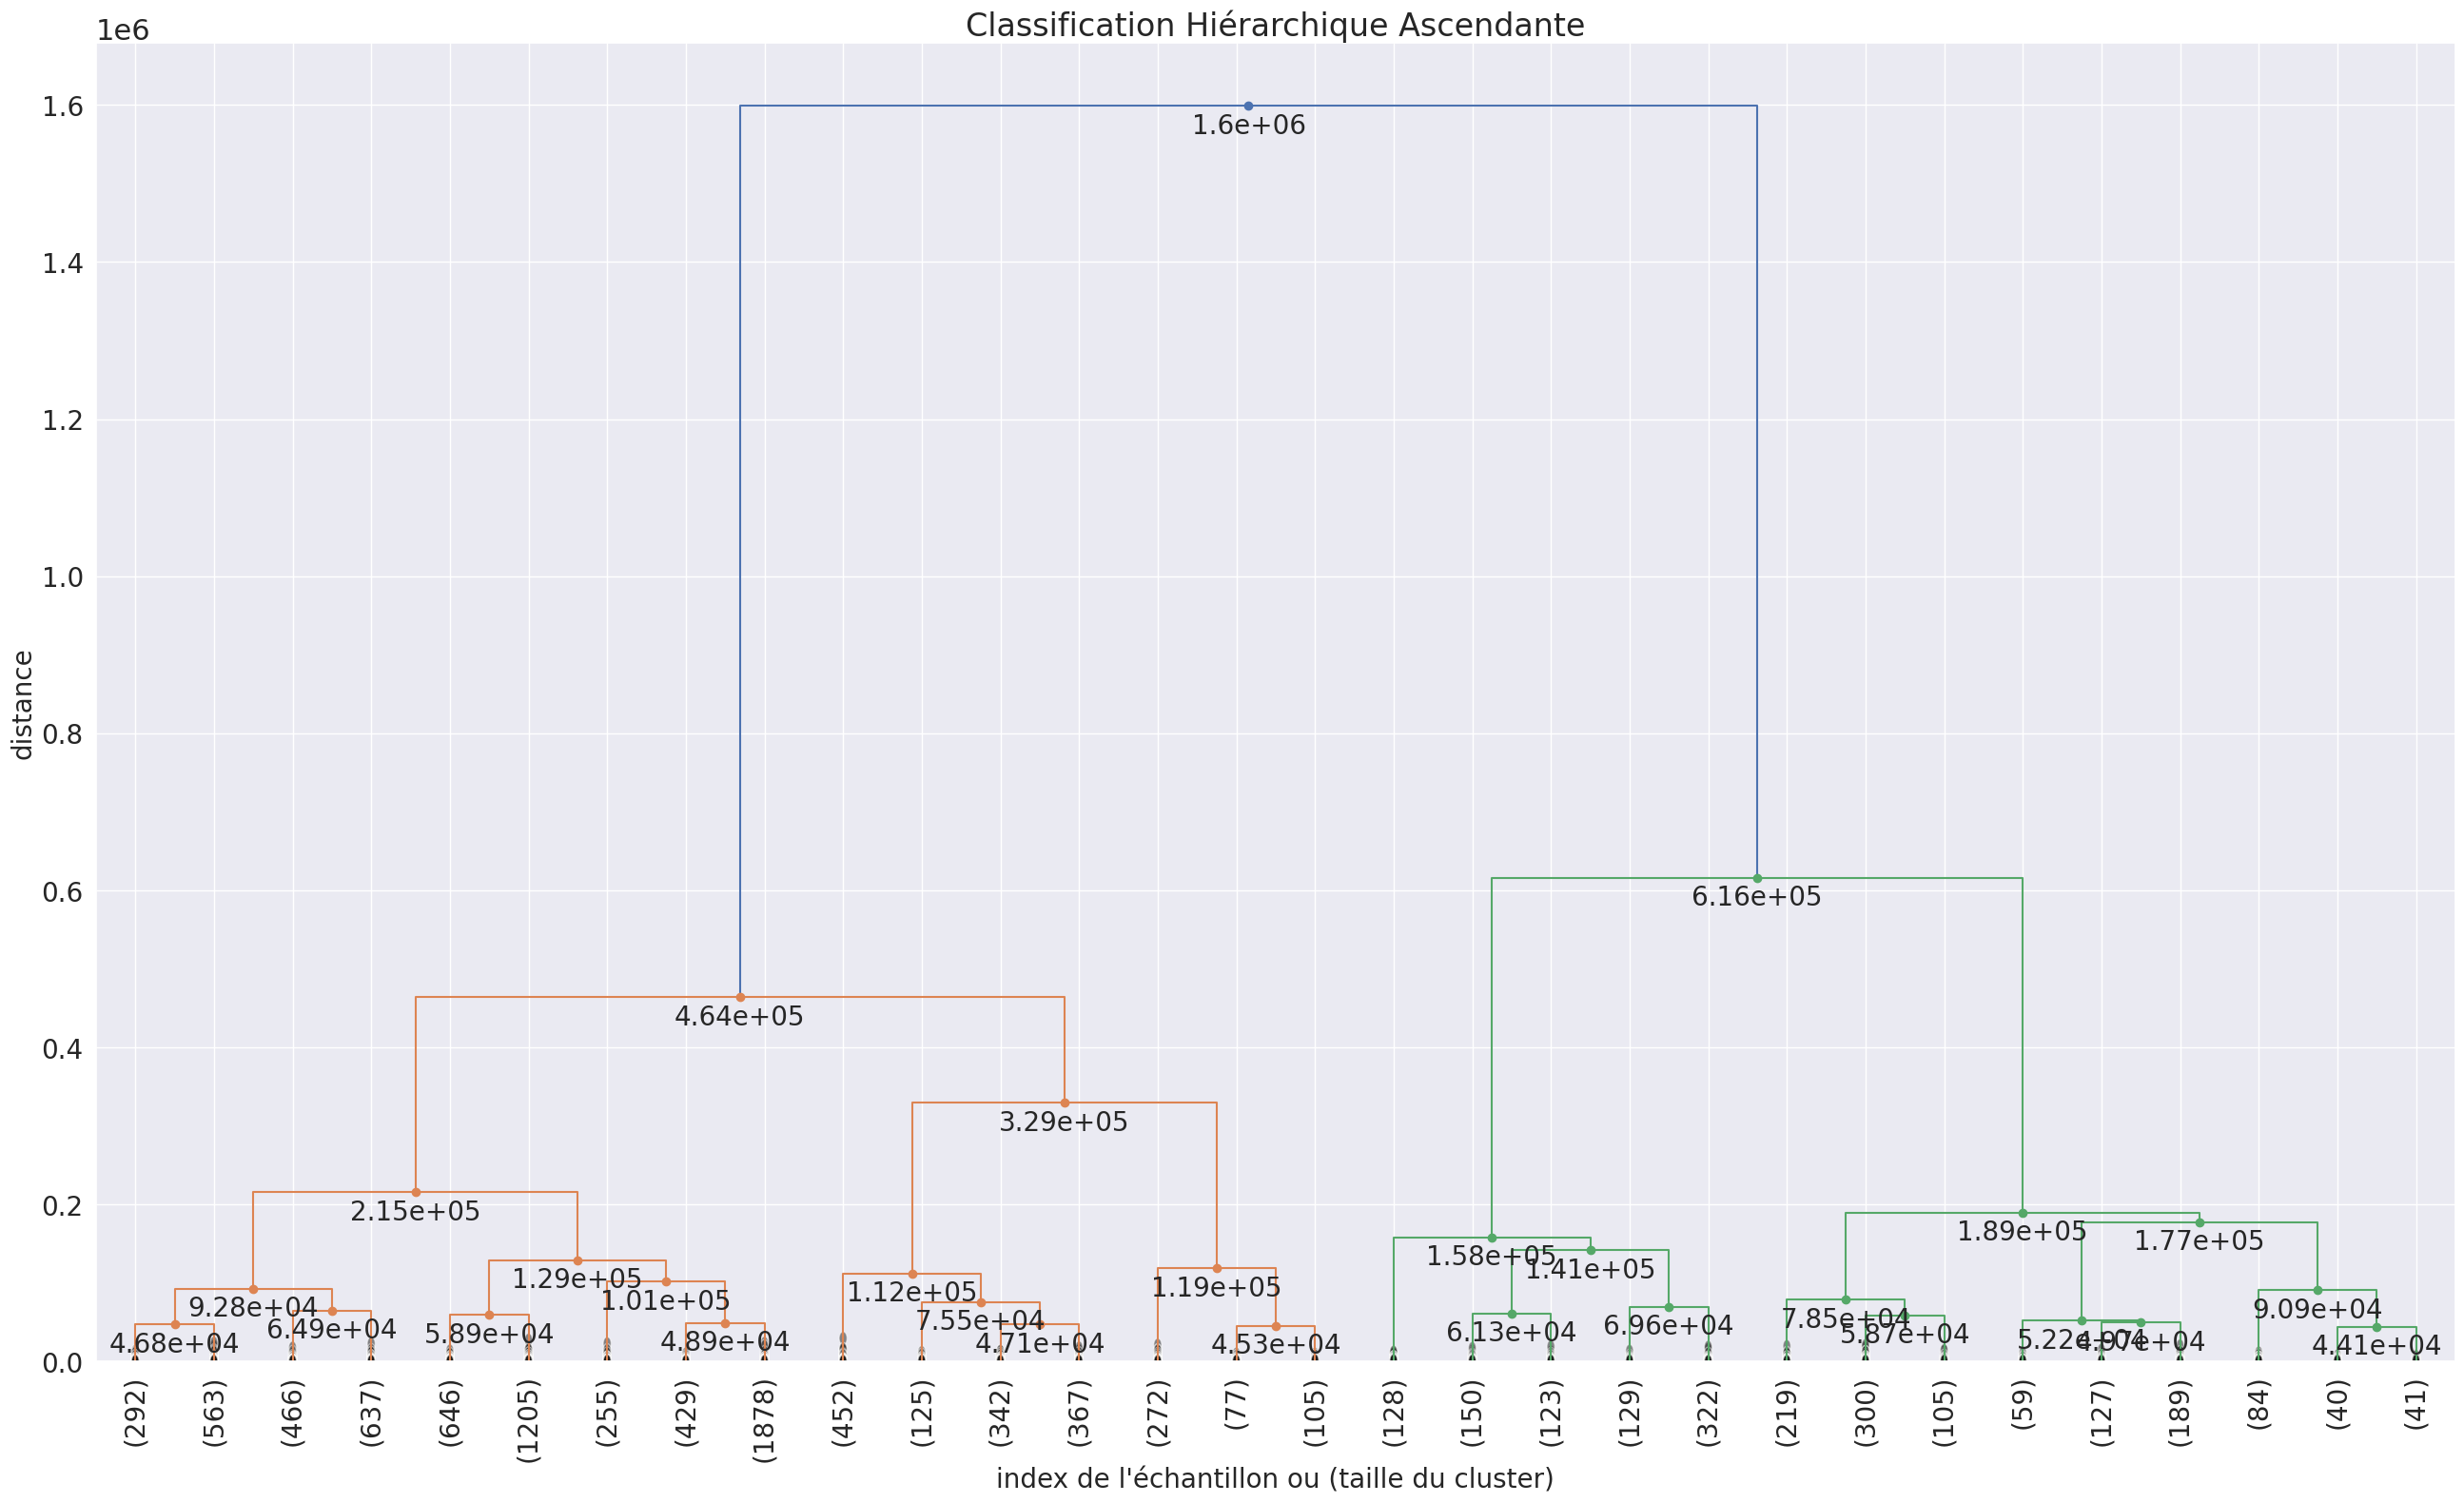

In [13]:
plt.figure(figsize=(32, 18))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=3,  
)
plt.show()

## 01- Jeu de données initial

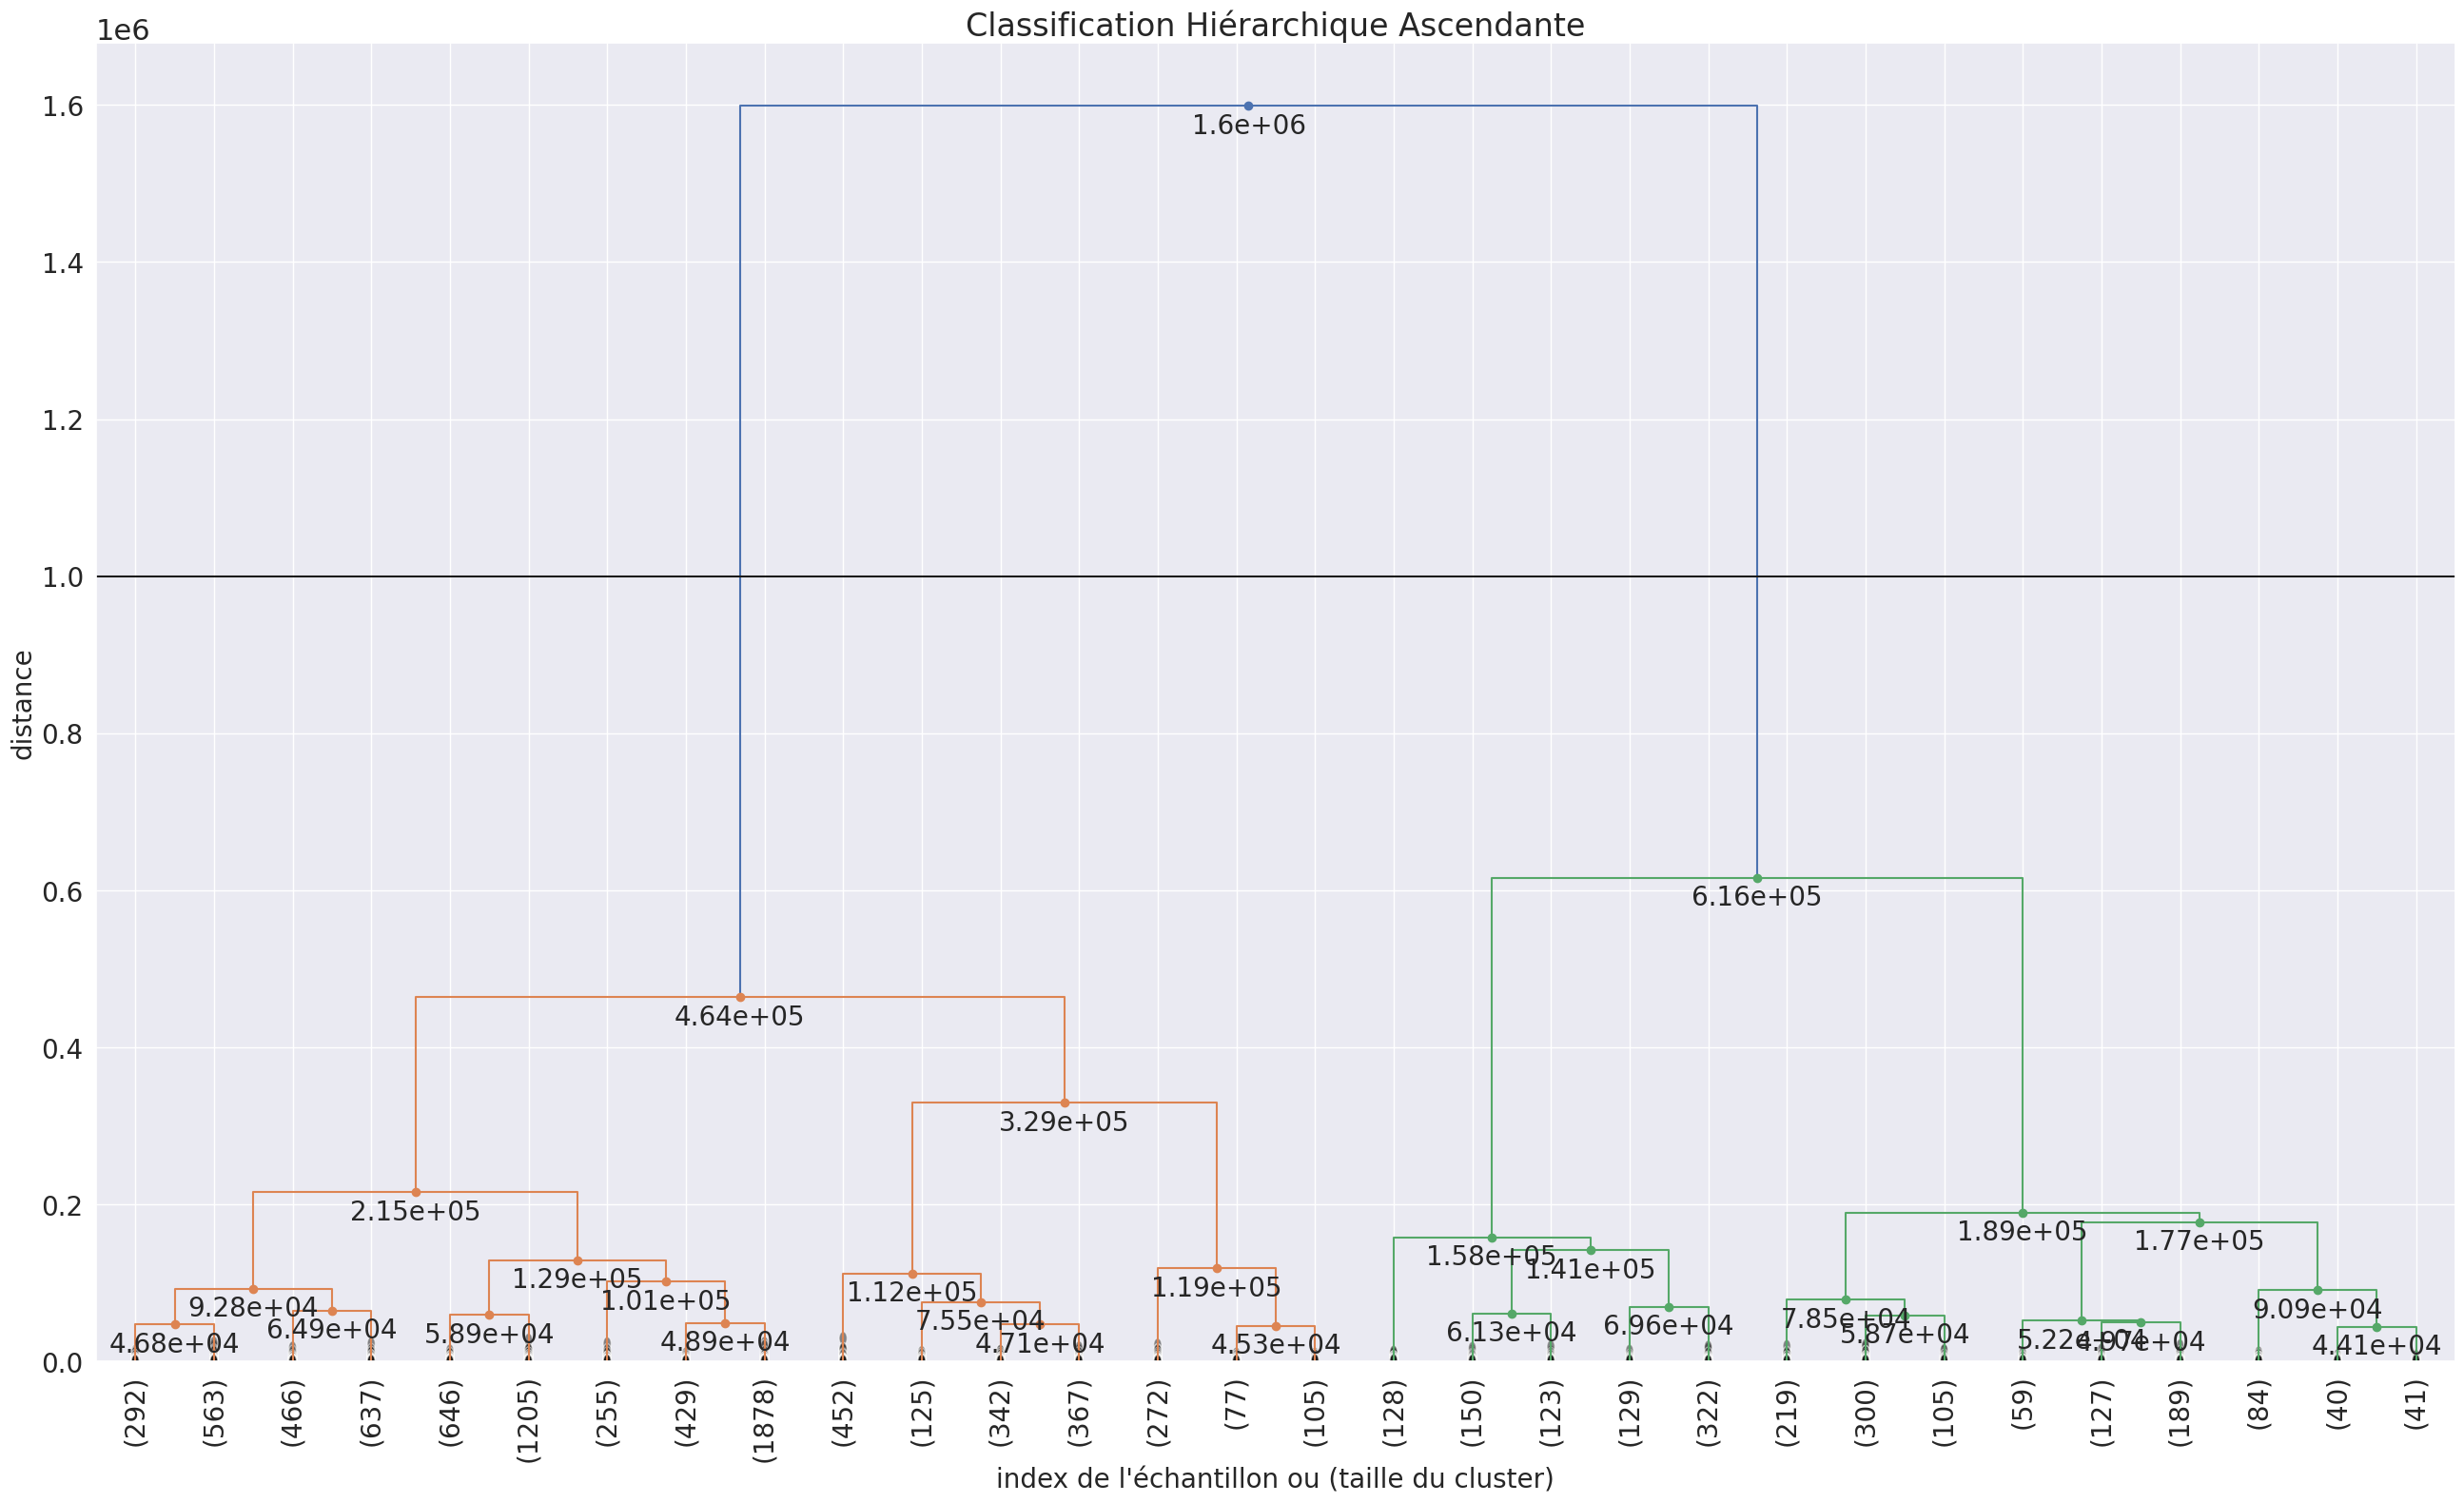

In [14]:
plt.figure(figsize=(32, 18))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=3, 
    max_d = 1.0e+6,
)
plt.show()

## 02 - Jeu de données initial

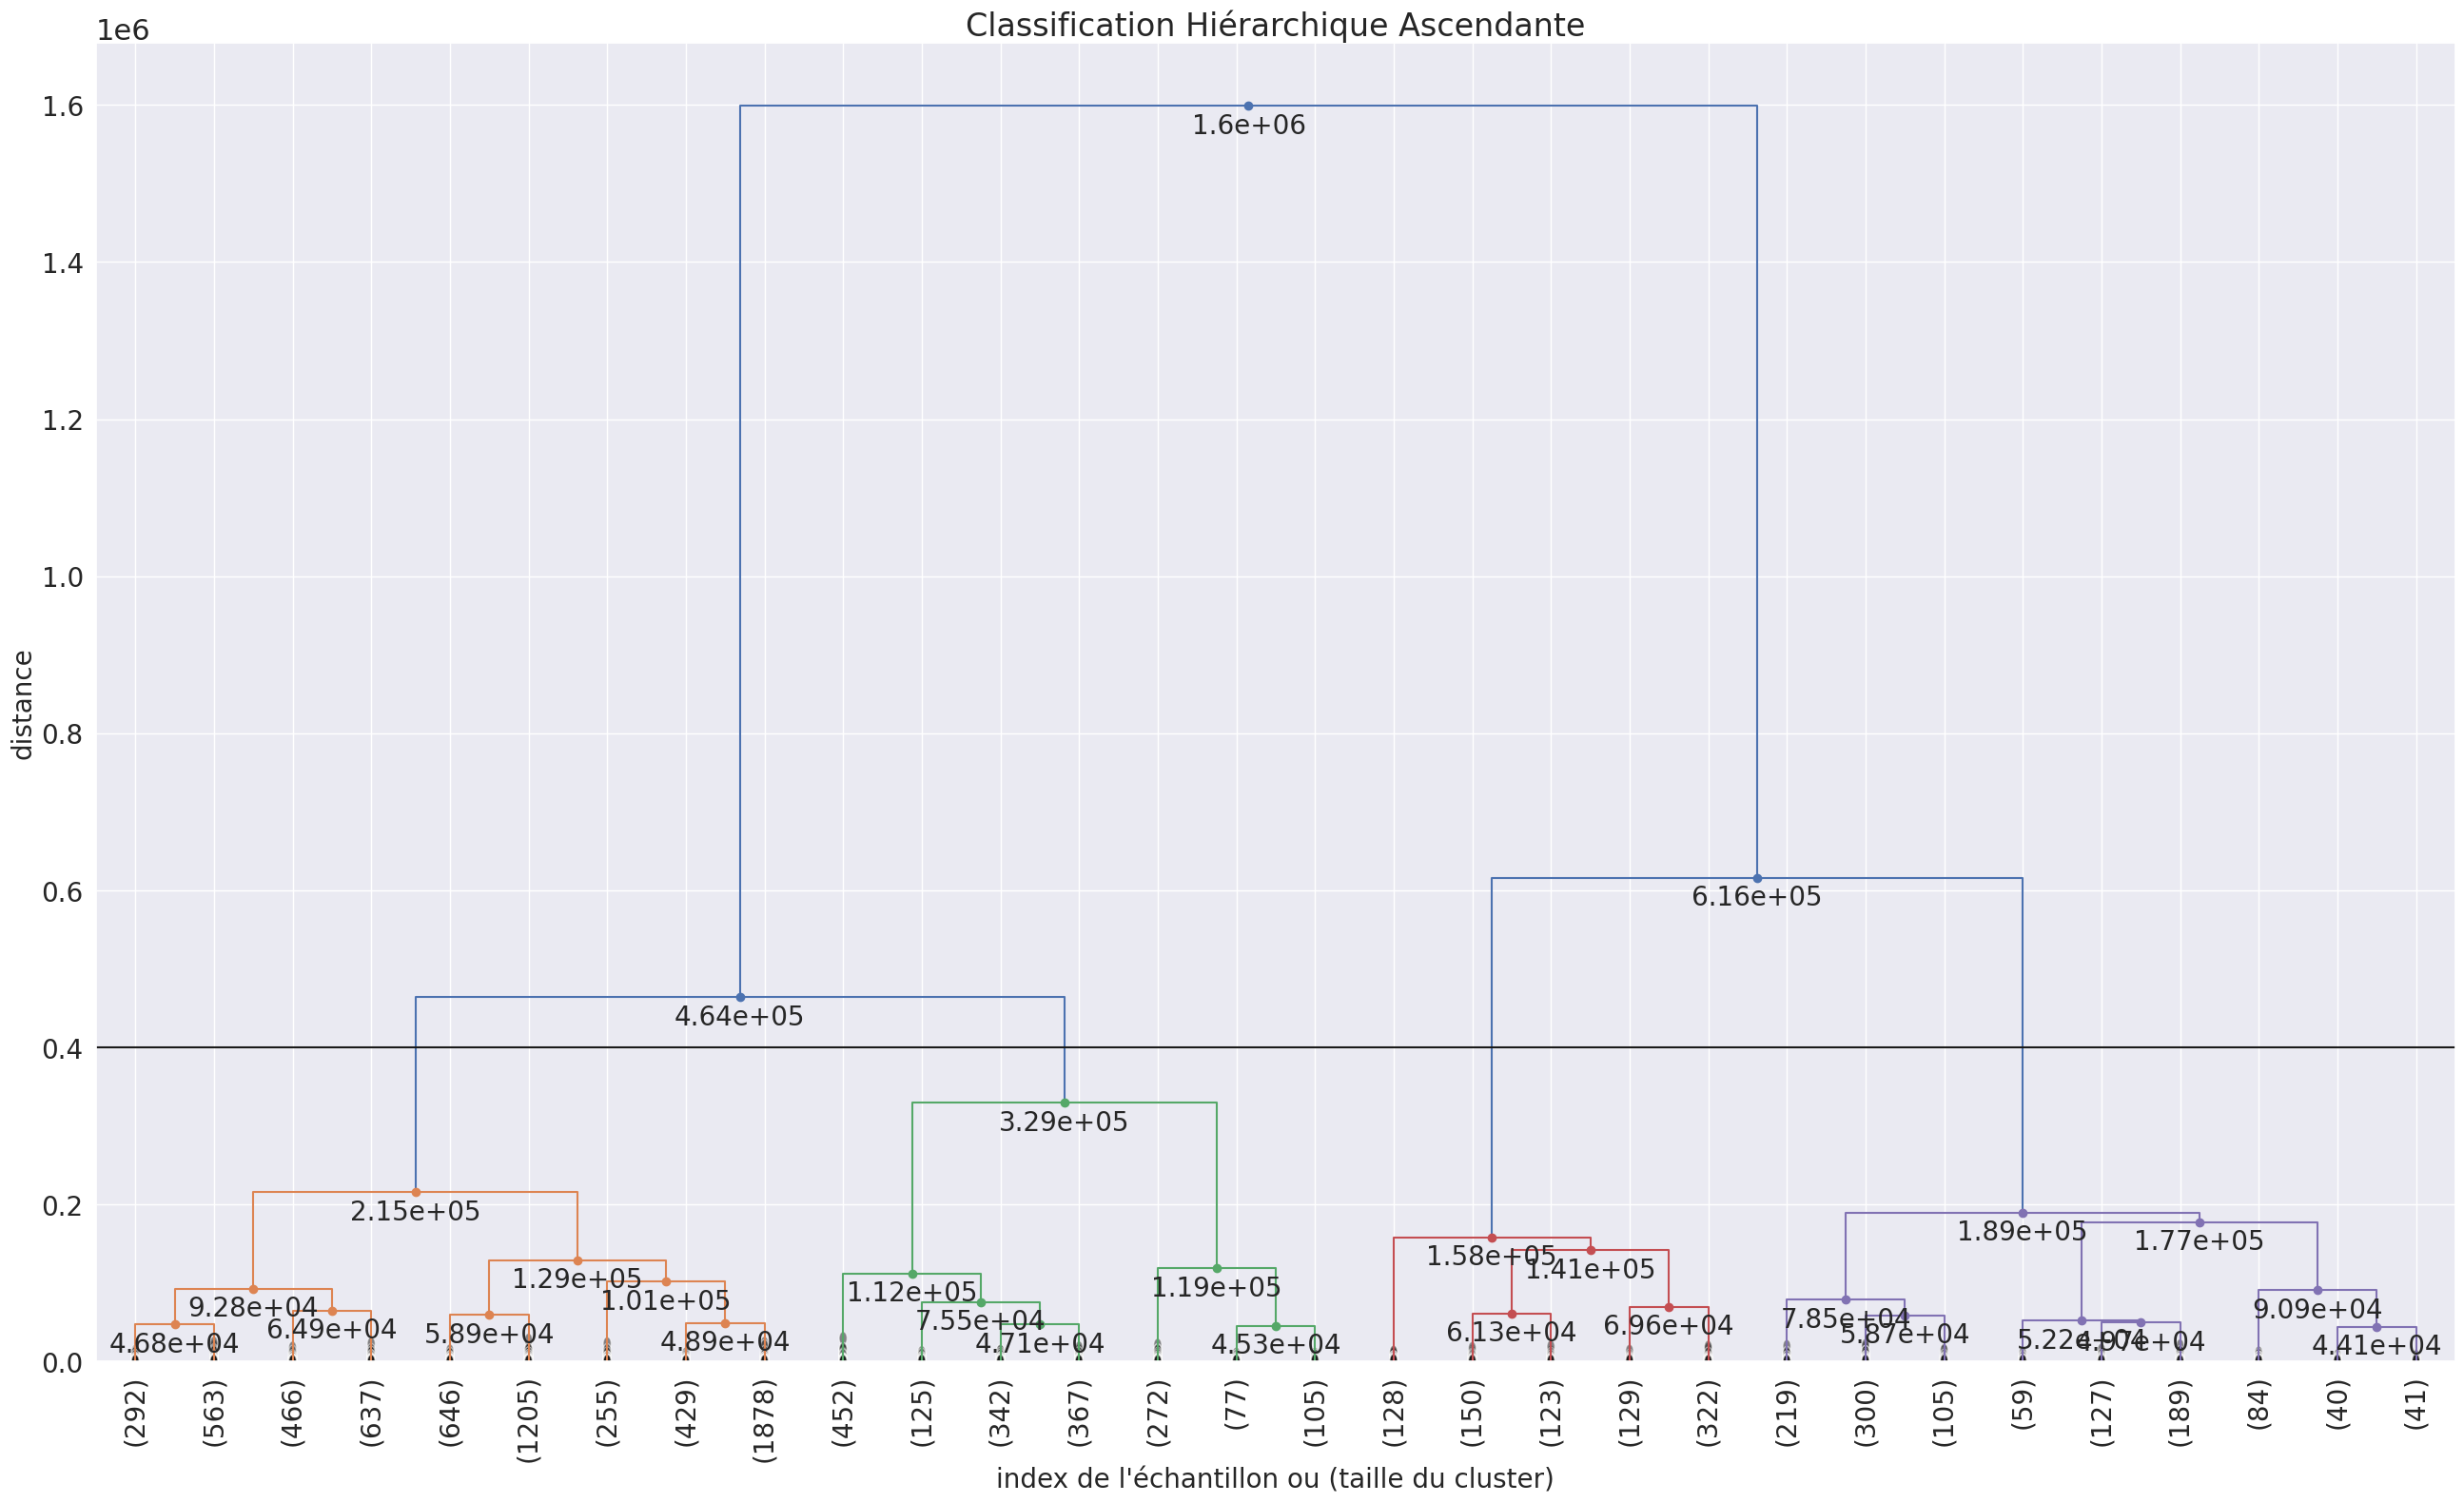

In [15]:
plt.figure(figsize=(32, 18))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=3, 
    max_d = 4e+5,
)
plt.show()

## 03 - Jeu de données initial

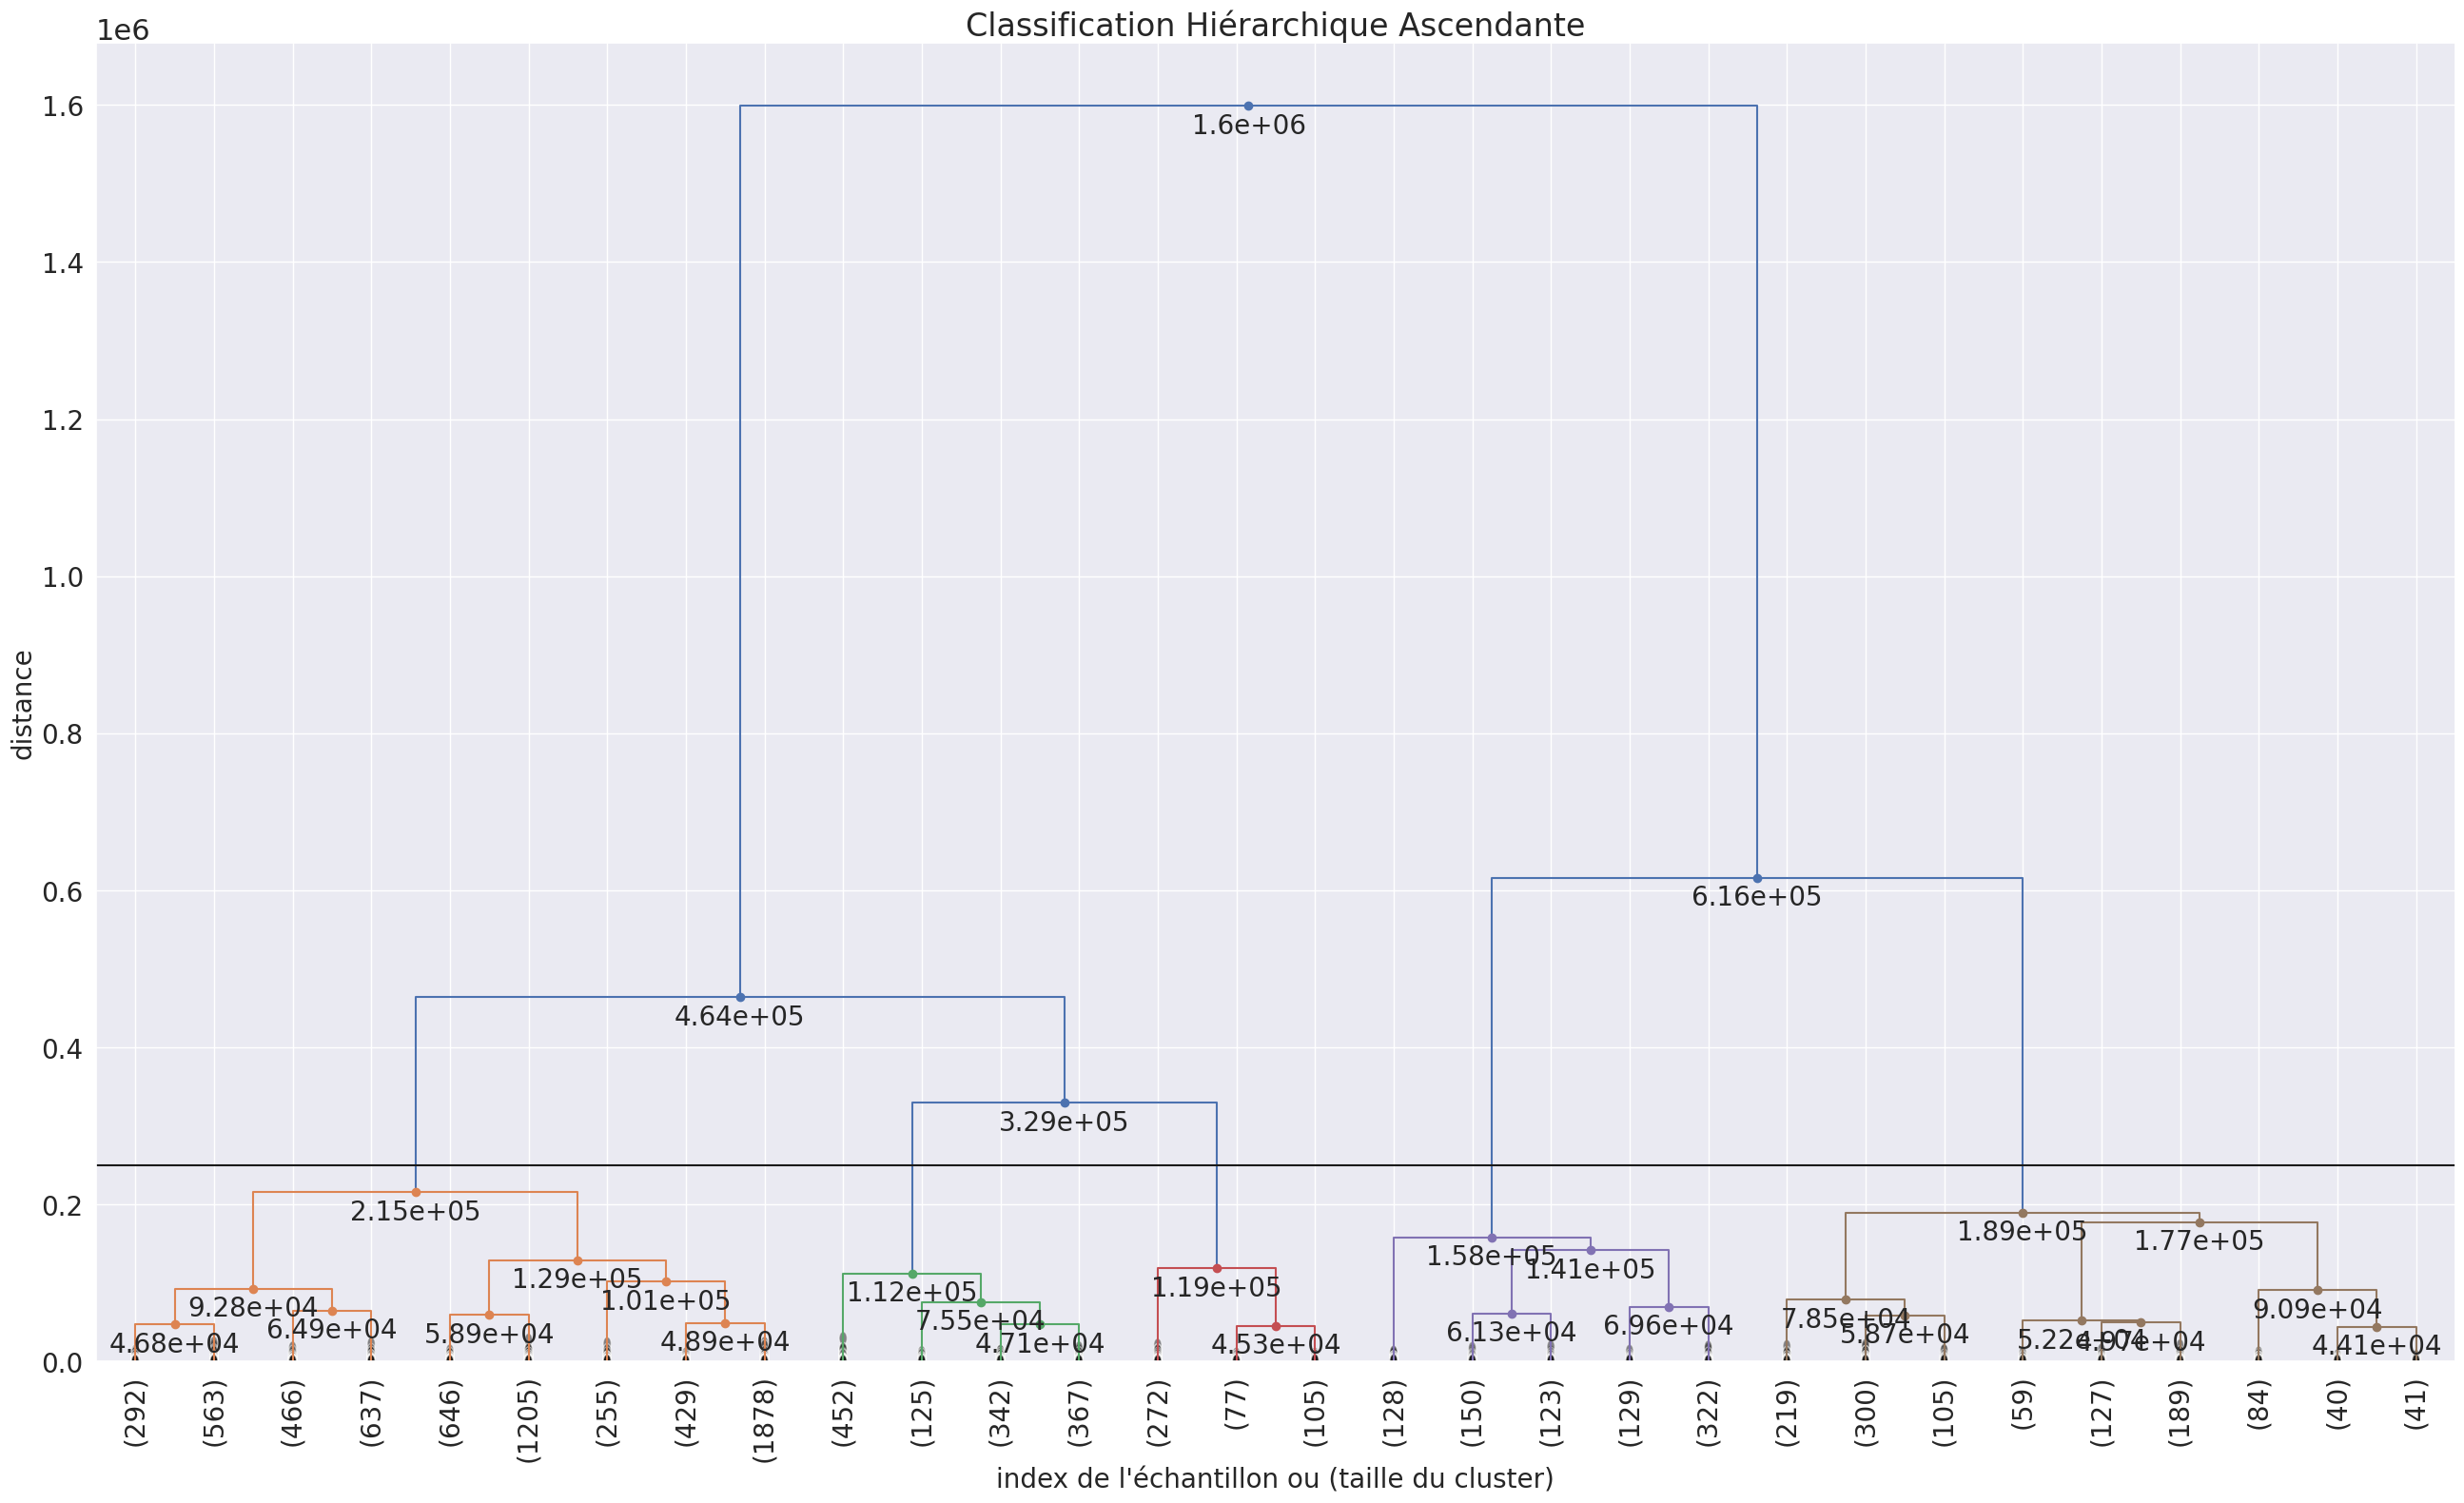

In [16]:
plt.figure(figsize=(32, 18))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=3, 
    max_d = 2.5e+5,
)
plt.show()

# Transformation des variables quantitatives

In [17]:
donnees[varQuantitatives+varQuantitativesDiscretes] = MinMaxScaler().fit_transform(donnees[varQuantitatives+varQuantitativesDiscretes])
donnees[varQuantitatives+varQuantitativesDiscretes].head()

,Credit_Limit,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Customer_Age,Months_on_book,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct
CLIENTNUM,,,,,,,,,,
768805383,0.340190,0.345116,0.392994,0.437534,0.061061,0.404255,0.604651,0.308701,0.035273,0.248062
818770008,0.206112,0.214093,0.453636,1.000000,0.105105,0.489362,0.720930,0.343266,0.043452,0.178295
713982108,0.059850,0.098948,0.763615,0.628164,0.000000,0.531915,0.534884,0.000000,0.076611,0.077519
769911858,0.056676,0.022977,0.413600,0.628164,0.760761,0.297872,0.488372,1.000000,0.036775,0.077519
709106358,0.099091,0.136557,0.640271,0.673129,0.000000,0.297872,0.186047,0.000000,0.017025,0.139535


In [18]:
Z = linkage(donnees, method='ward')

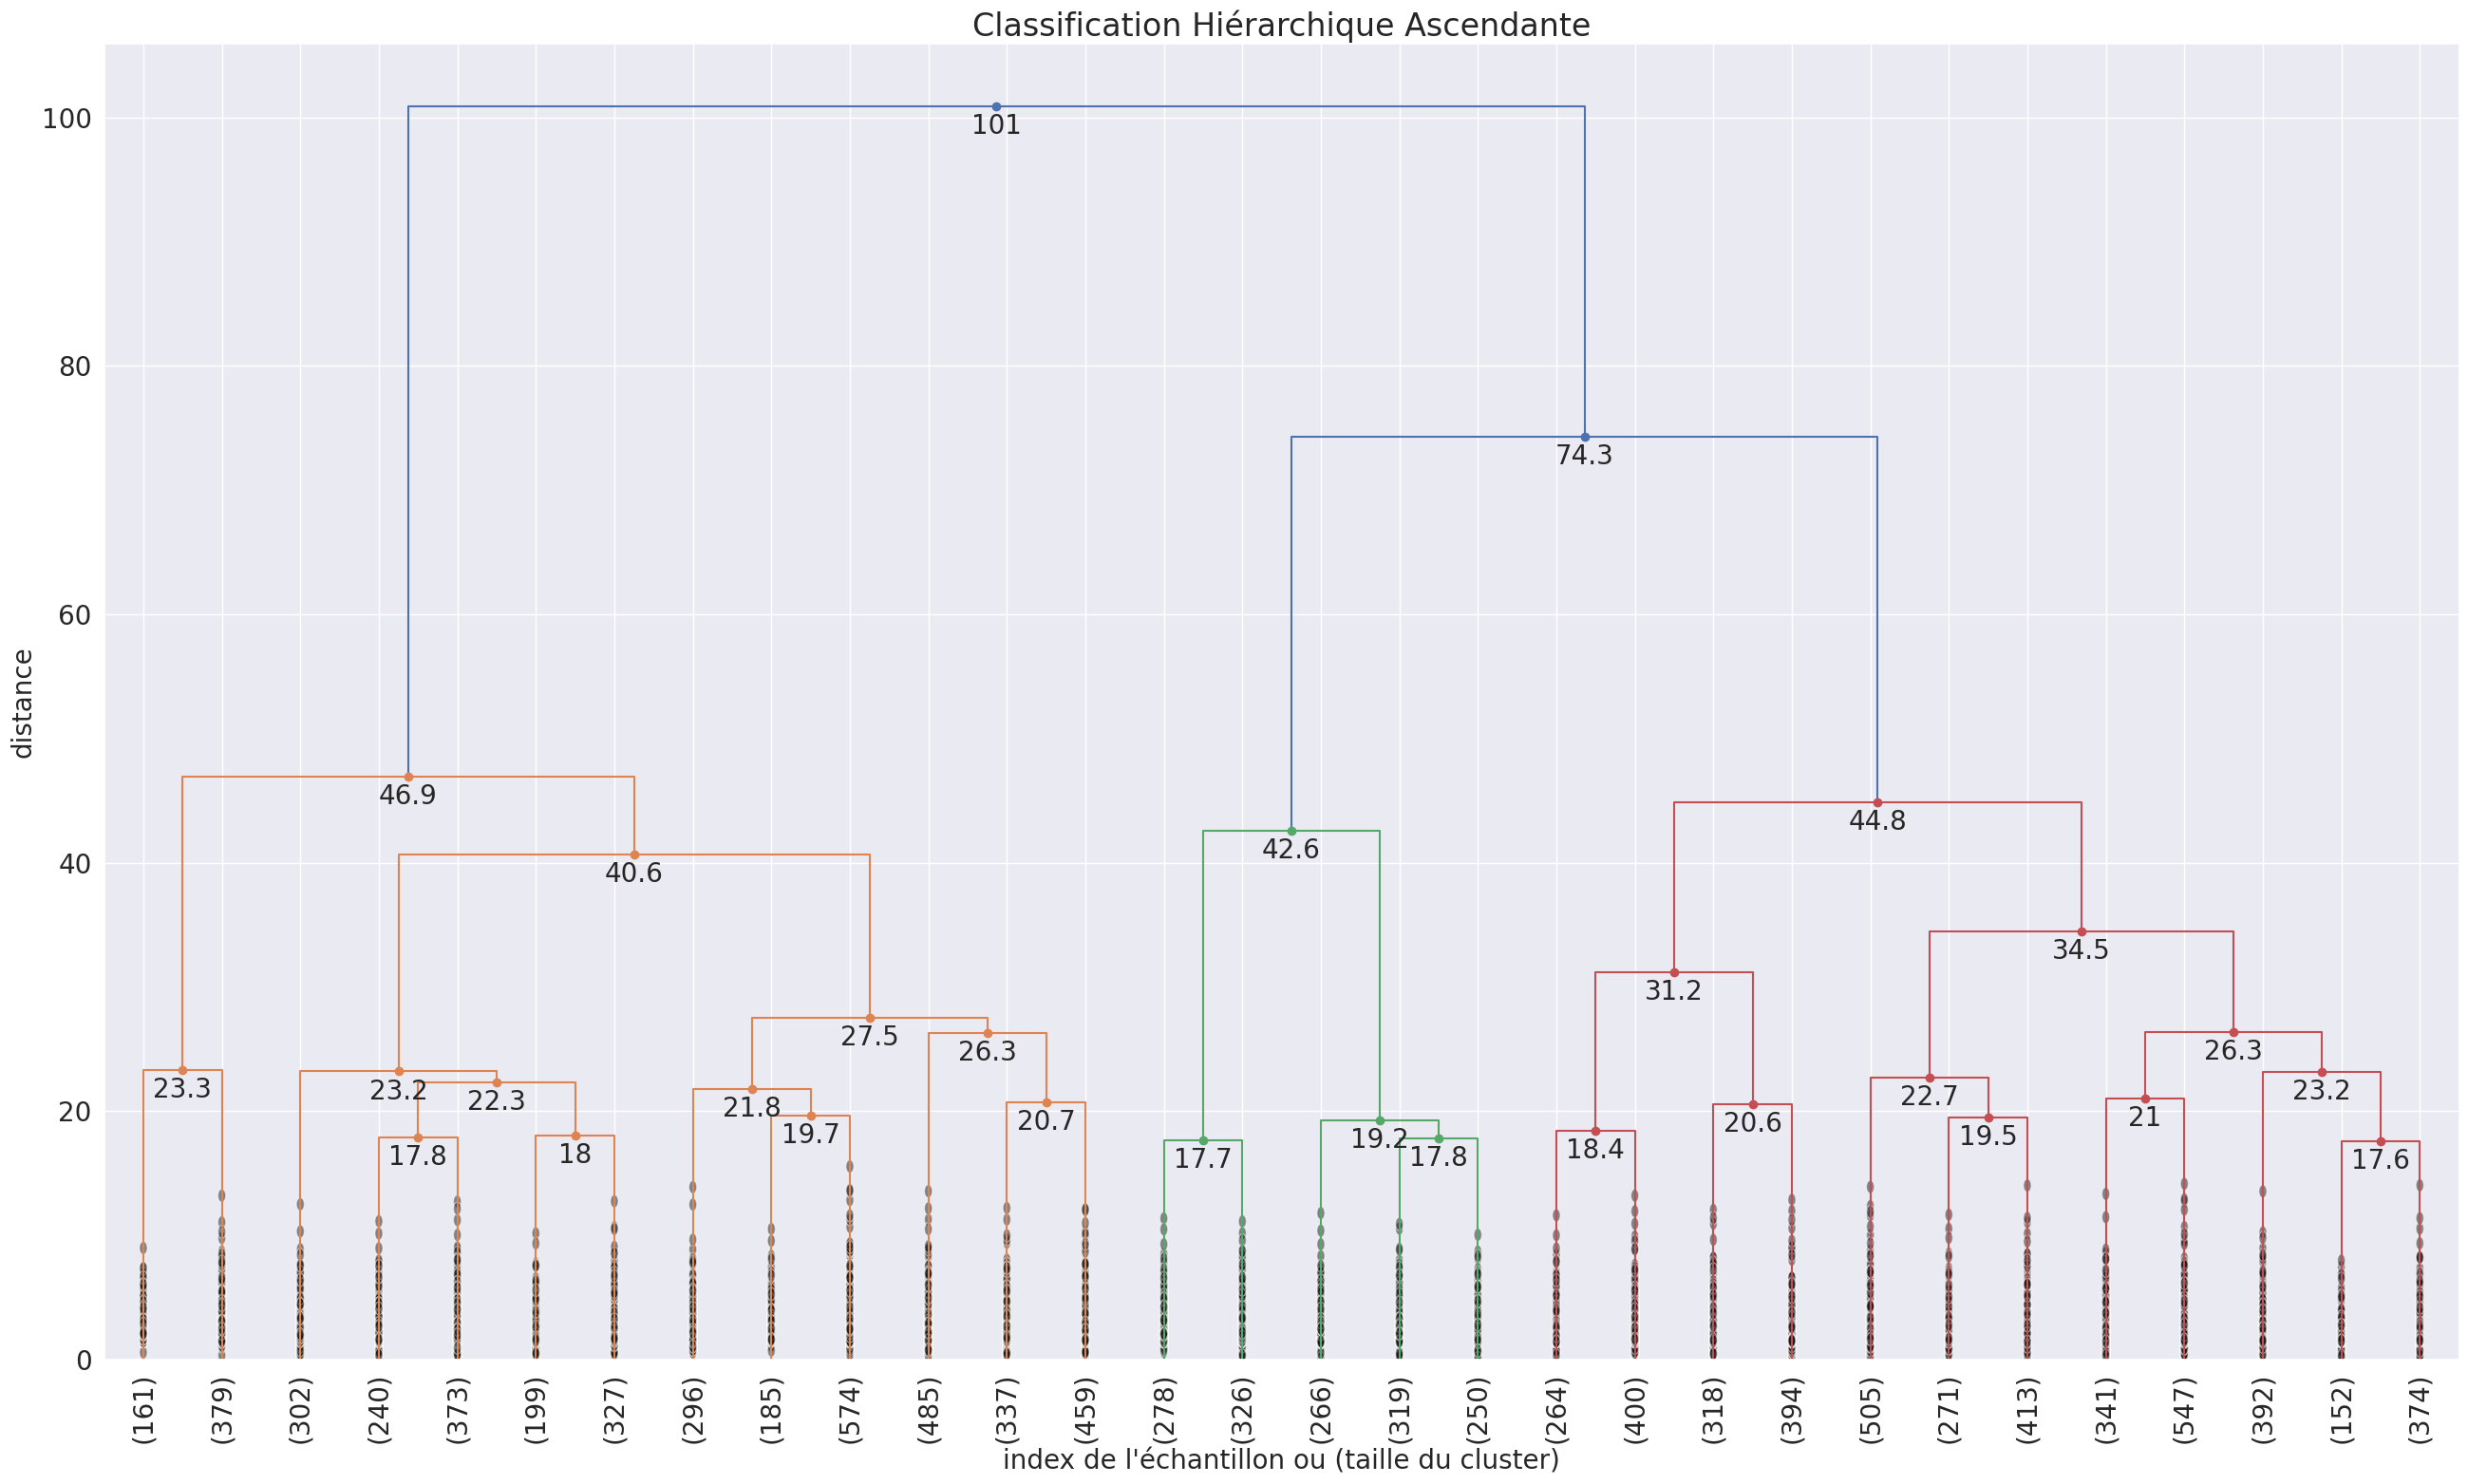

In [19]:
plt.figure(figsize=(32, 18))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=3,  
)
plt.show()

## 01 - Jeu de données transformé

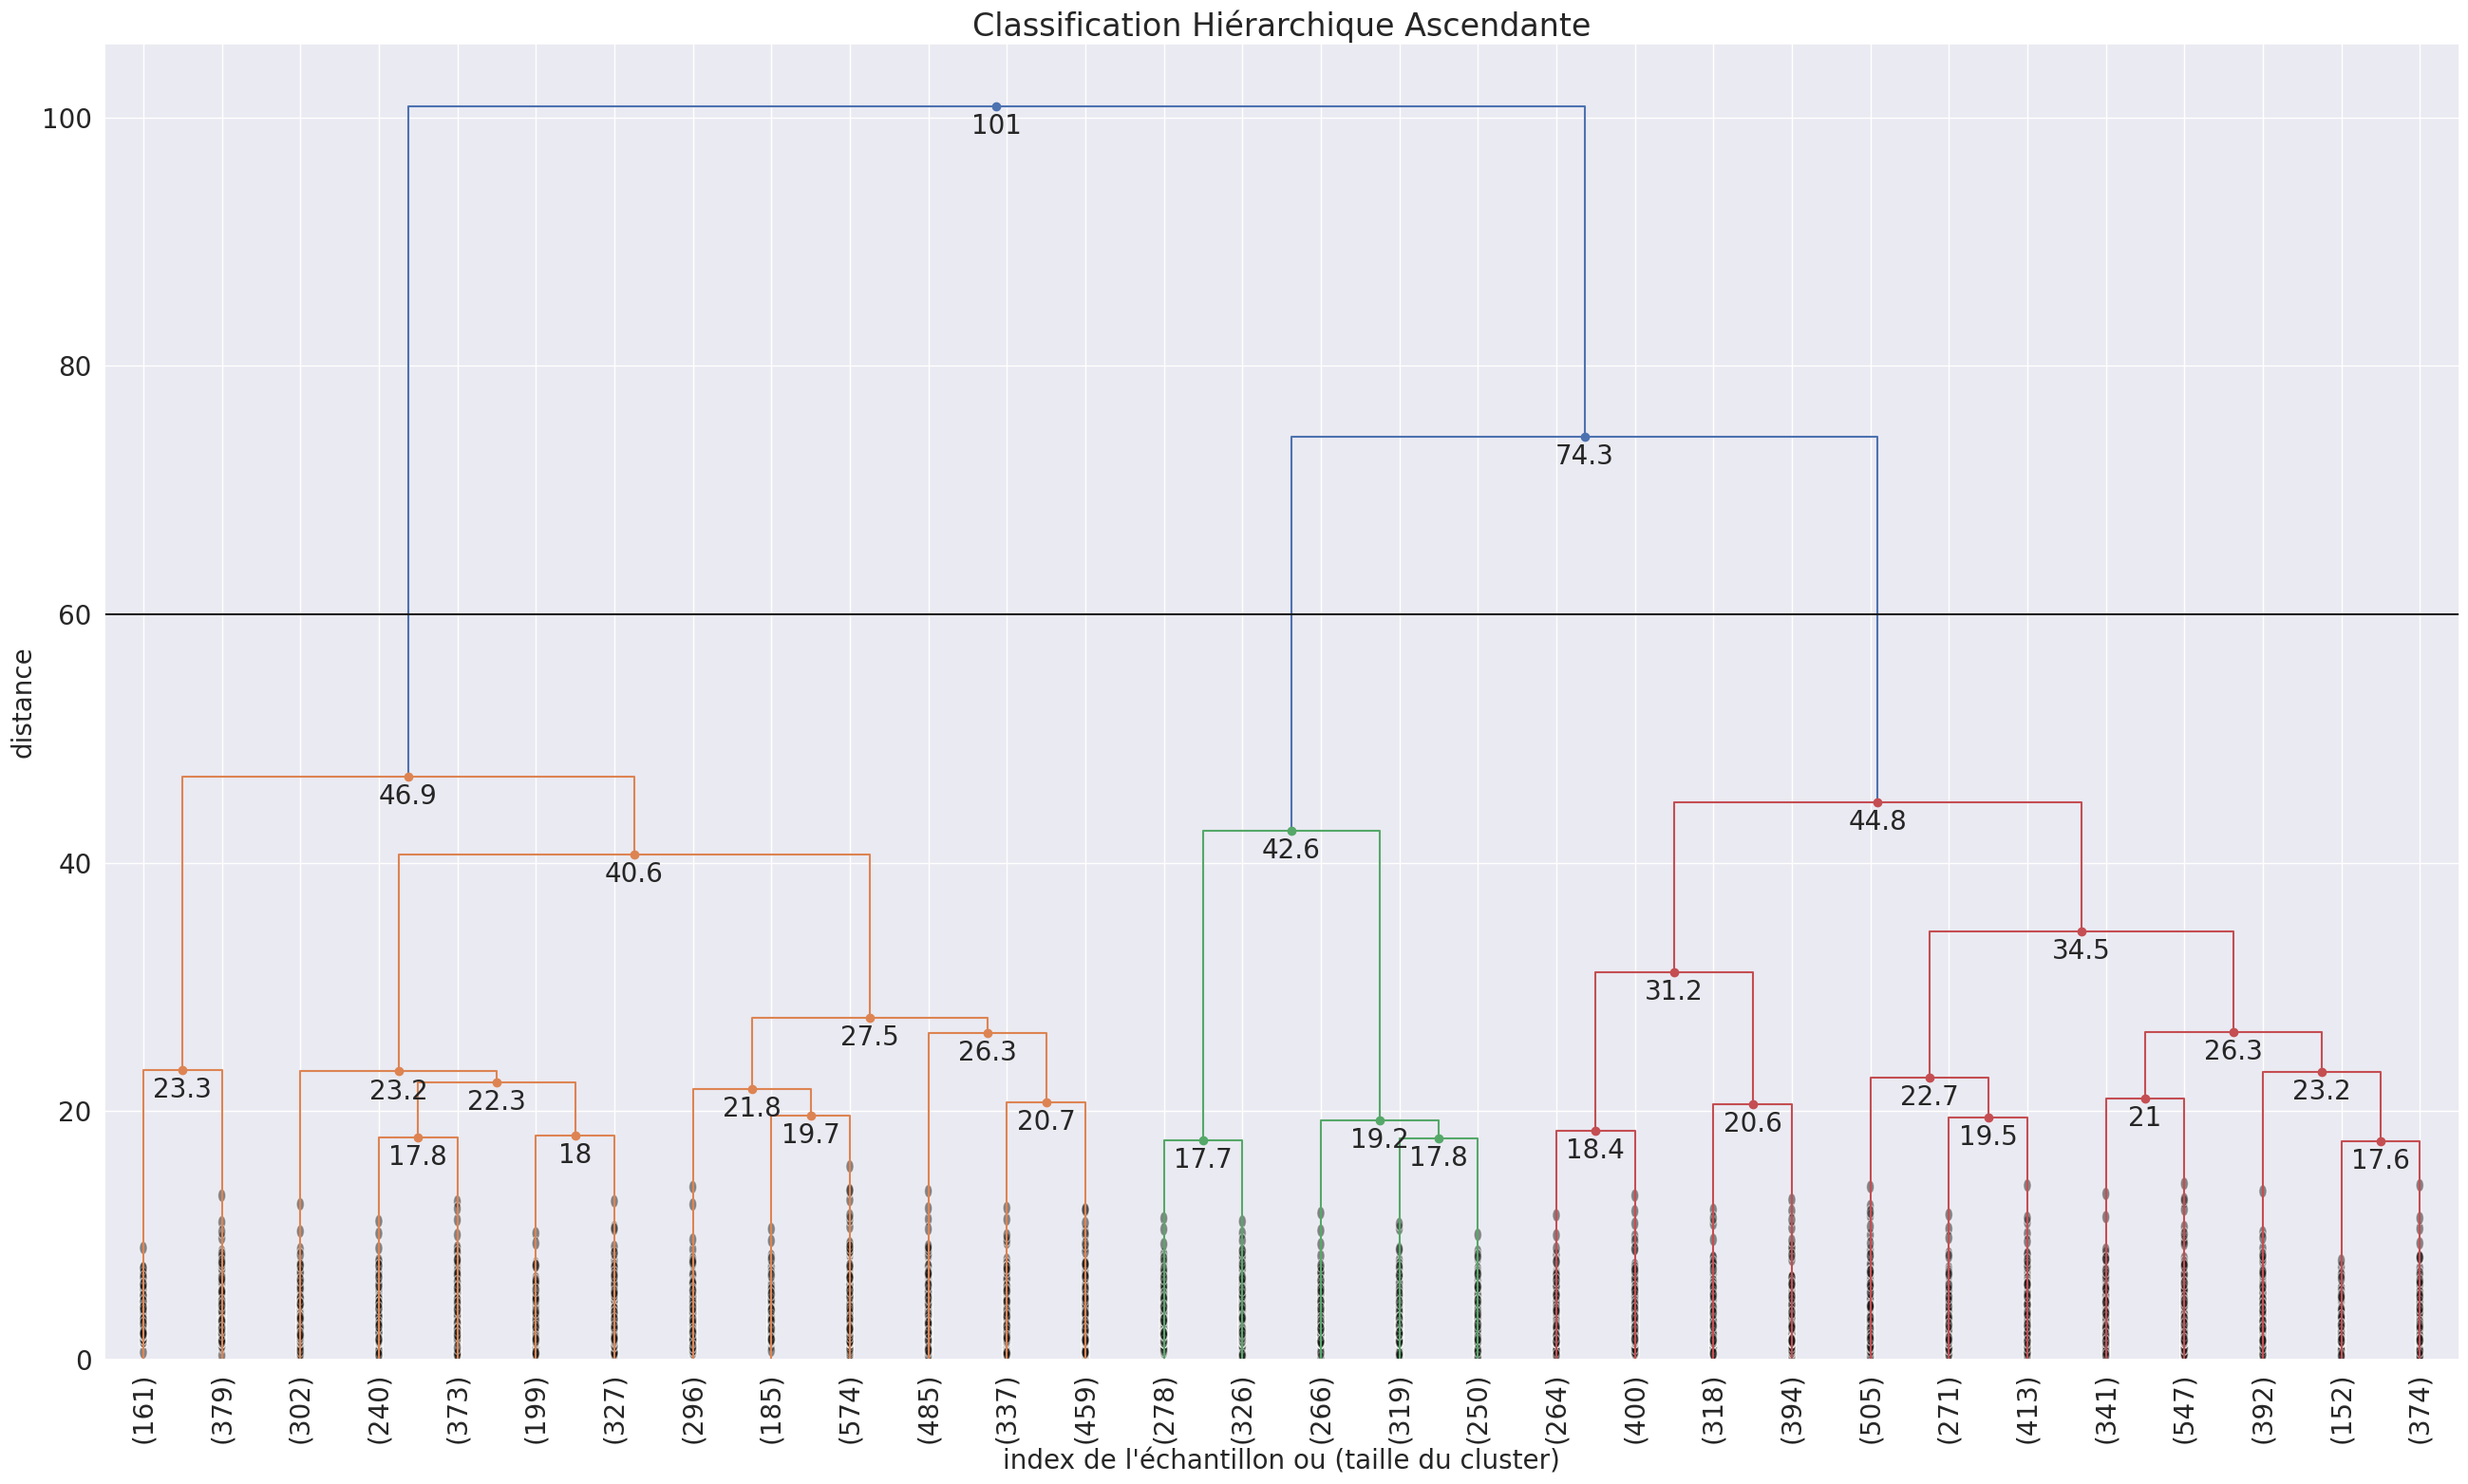

In [20]:
plt.figure(figsize=(32, 18))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=3, 
    max_d = 60,
)
plt.show()

## 02 - Jeu de données transformé

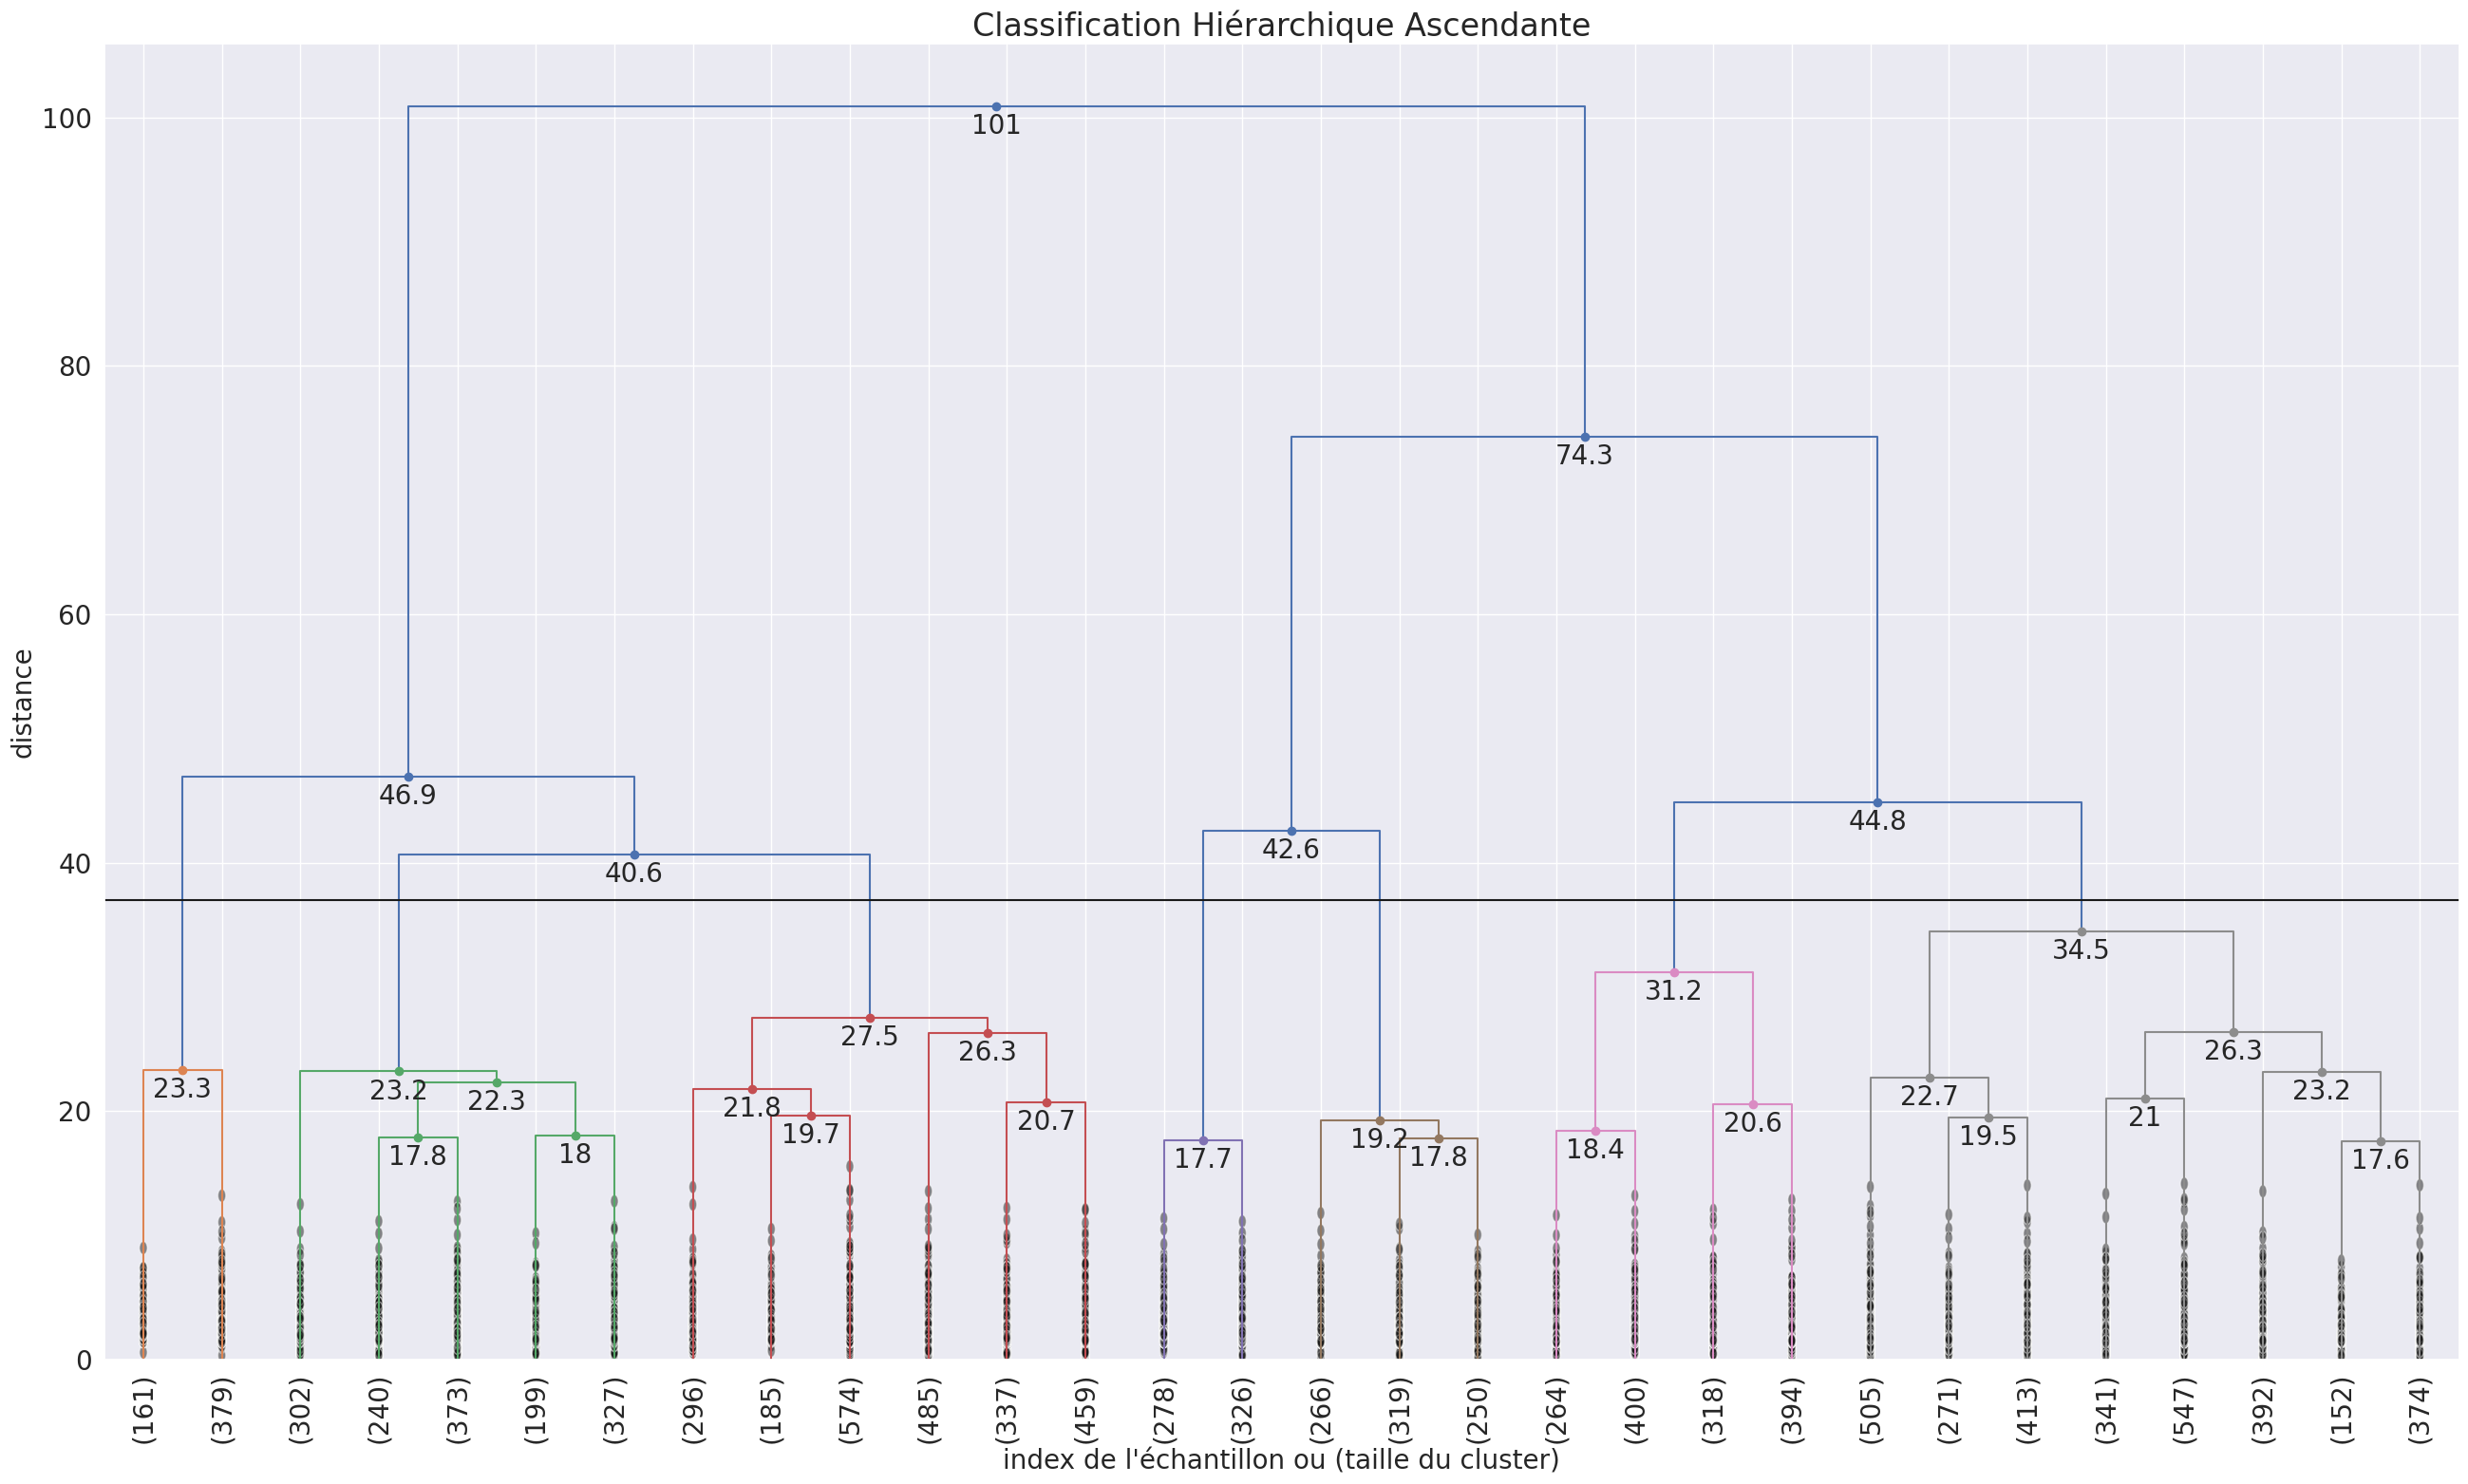

In [21]:
plt.figure(figsize=(32, 18))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=3, 
    max_d = 37,
)
plt.show()

In [22]:
donnees['Segments-3']=fcluster(Z, t=60, criterion='distance')
donnees['Segments-7']=fcluster(Z, t=37, criterion='distance')

# Analyse 01 - Jeu de données transformé

In [23]:
X_train, X_test, y_train, y_test = train_test_split(donnees.drop(columns=['Segments-3','Segments-7']), 
                                                    donnees['Segments-3'], 
                                                    test_size=0.40, 
                                                    random_state = 5,
                                                    stratify= donnees['Segments-3'])

In [24]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto'],
    'max_depth' : [None,3,5,8],
    'criterion' :['gini'],
    'min_samples_split':[2,3,4]
}

rf_models = GridSearchCV(RandomForestClassifier(random_state = 5), param_grid=param_grid, cv=5, verbose=1)
rf_models.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
             param_grid={'criterion': ['gini'], 'max_depth': [None, 3, 5, 8],
                         'max_features': ['auto'],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

## 01 - Jeu de données transformé -- Performance du modèle

In [25]:
predictions = rf_models.predict(X_test)
print("Accuracy:",metrics.accuracy_score(predictions, y_test))

Accuracy: 0.9624784003949642


## 01 - Jeu de données transformé -- Importance des variables

In [26]:
feature_importance = pd.DataFrame(data={"Variables":X_test.columns, "importance %":rf_models.best_estimator_.feature_importances_*100})
feature_importance.sort_values("importance %", ascending=False).head(10).style.background_gradient(cmap='coolwarm', low=1, high=0)

,Variables,importance %
12,Gender_F,21.225759
13,Gender_M,17.902521
10,Attrition_Flag_Attrited Customer,10.610315
11,Attrition_Flag_Existing Customer,10.603390
29,Income_Category_Less than $40K,4.638828
2,Credit_Limit,3.304465
6,Total_Trans_Amt,2.990834
4,Avg_Open_To_Buy,2.841730
7,Total_Trans_Ct,2.533744
27,Income_Category_$60K - $80K,2.045570


# Analyse 02 - Jeu de données transformé

In [27]:
X_train, X_test, y_train, y_test = train_test_split(donnees.drop(columns=['Segments-3','Segments-7']), 
                                                    donnees['Segments-7'], 
                                                    test_size=0.40, 
                                                    random_state = 5,
                                                    stratify= donnees['Segments-7'])

In [28]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto'],
    'max_depth' : [None,3,5,8],
    'criterion' :['gini'],
    'min_samples_split':[2,3,4]
}

# Entraînement dy modèles RF Training RF Models with K-Fold of 5 
rf_models = GridSearchCV(RandomForestClassifier(random_state = 5), param_grid=param_grid, cv=5, verbose=1)
rf_models.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
             param_grid={'criterion': ['gini'], 'max_depth': [None, 3, 5, 8],
                         'max_features': ['auto'],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

## 02 - Jeu de données transformé -- Performance du modèle

In [29]:
predictions = rf_models.predict(X_test)
print("Accuracy:",metrics.accuracy_score(predictions, y_test))

Accuracy: 0.8654653172056282


## 02 - Jeu de données transformé -- Importance des variables

In [30]:
feature_importance = pd.DataFrame(data={"Variables":X_test.columns, "importance %":rf_models.best_estimator_.feature_importances_*100})
feature_importance.sort_values("importance %", ascending=False).head(10).style.background_gradient(cmap='coolwarm', low=1, high=0)

,Variables,importance %
12,Gender_F,11.256488
29,Income_Category_Less than $40K,9.033989
13,Gender_M,8.738491
10,Attrition_Flag_Attrited Customer,6.384994
11,Attrition_Flag_Existing Customer,6.165810
23,Marital_Status_Single,4.473174
4,Avg_Open_To_Buy,3.819378
2,Credit_Limit,3.802580
22,Marital_Status_Married,3.346136
7,Total_Trans_Ct,3.043553
